In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this example we are going to train 3 image classifiers using the [BigEarthNet](http://bigearth.net/) dataset:

1. Using S1 images
2. Using S2 images
3. Using both S1 and S2 images in a Data Fusion manner.

## Sentinel 1

In [49]:
from pytorch_eo.datasets.big_earth_net import BigEarthNet
from pytorch_eo.datasets.big_earth_net.utils import LABELS19
from pytorch_eo.utils.sensors import Sensors, S1

ds = BigEarthNet(
    path="./data/BigEarthNet", 
    batch_size=25, 
	bands={Sensors.S1: [S1.VH, S1.VV]}, # dict with sensor: bands
    verbose=True,
    label_groups=LABELS19
)

ds.setup()

Loading ... processed_S1_LABELS19.json
training samples 60
validation samples 20
test samples 20


In [50]:
ds.df

,s1_images,labels,encoded_labels
0,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,"[Arable land, Land principally occupied by agr...","[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, ..."
2,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,"[Arable land, Pastures]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,"[Permanent crops, Moors, heathland and sclerop...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
95,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,"[Coniferous forest, Mixed forest]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
96,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,"[Coniferous forest, Mixed forest]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
97,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,"[Coniferous forest, Mixed forest, Transitional...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ..."
98,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,"[Broad-leaved forest, Mixed forest, Inland wat...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..."


In [51]:
ds.num_classes, ds.classes

(19,
 ['Urban fabric',
  'Industrial or commercial units',
  'Arable land',
  'Permanent crops',
  'Pastures',
  'Complex cultivation patterns',
  'Land principally occupied by agriculture, with significant areas of natural vegetation',
  'Agro-forestry areas',
  'Broad-leaved forest',
  'Coniferous forest',
  'Mixed forest',
  'Natural grassland and sparsely vegetated areas',
  'Moors, heathland and sclerophyllous vegetation',
  'Transitional woodland, shrub',
  'Beaches, dunes, sands',
  'Inland wetlands',
  'Coastal wetlands',
  'Inland waters',
  'Marine waters'])

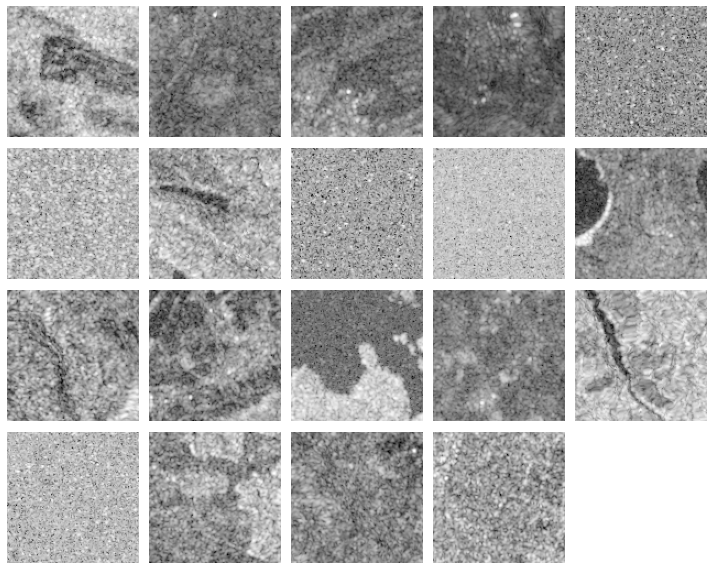

In [52]:
import matplotlib.pyplot as plt

imgs, labels = next(iter(ds.train_dataloader()))

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    if img.ndim == 2:
        ax.imshow(img, cmap="gray") # one band 
    else:
        ax.imshow(img[...,0], cmap="gray") # first band
    # ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()